In [1]:
import sys
sys.path.append('../../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

import matplotlib.pyplot as plt

2024-09-04 11:31:50.779915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 11:31:50.779943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 11:31:50.781249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
MOM6_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_'
L = 'all'
window_size=3

In [3]:
ML_data = datasets.MOM6_all_transformer('-', 'all', 
                                       input_channels = ['U_x', 'U_y', 
                                                         'V_x', 'V_y', 
                                                         'Sx', 'Sy'])

In [4]:
ML_data.read_datatree(MOM6_bucket, 
                      file_names='', # need this for file names in DG sim
                      keep_filt_scale=True, 
                      para_perp_out = True, 
                      eta_bottom=True,
                      large_filt=4,
                      H_mask=150,
                      sub_sample=True, 
                      window_size=window_size)

Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_50km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_100km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_200km.zarr
Out para perp
Subsampling
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5km/ml_data_400km.zarr
Out para perp
Subsampling


In [6]:
ML_data.generate_test_train_batches(normalize=False, input_dims = {'Xn':window_size,'Yn':window_size})

Test and train batches split. Number of batches: 37-5


In [7]:
ML_data.ds_train

<xarray.Dataset> Size: 947MB
Dimensions:  (Xn: 3, Yn: 3, points: 2660040)
Coordinates:
    zl       float64 8B 1.036e+03
  * points   (points) object 21MB MultiIndex
  * Time     (points) object 21MB 0015-01-18 00:00:00 ... 0071-11-30 00:00:00
  * xh       (points) float64 21MB 16.94 7.26 14.19 15.95 ... 13.31 10.12 6.38
  * yh       (points) float64 21MB 40.73 45.09 45.73 34.82 ... 43.55 41.27 41.45
Dimensions without coordinates: Xn, Yn
Data variables:
    Sfnx     (Xn, Yn, points) float32 96MB -0.01098 -0.1672 ... -0.1732 -0.1283
    Sfny     (Xn, Yn, points) float32 96MB 0.01825 0.2551 ... 0.1503 0.0439
    U_x      (Xn, Yn, points) float32 96MB -5.3e-09 1.35e-07 ... -5.431e-08
    U_y      (Xn, Yn, points) float32 96MB 3.097e-09 -6.728e-08 ... 1.022e-07
    V_x      (Xn, Yn, points) float32 96MB 3.729e-08 1.151e-07 ... -1.467e-07
    V_y      (Xn, Yn, points) float32 96MB 5.685e-09 -1.509e-07 ... 5.983e-08
    Sx       (Xn, Yn, points) float32 96MB -7.848e-05 0.0002685 ... -0.0001532
    Sy       (Xn, Yn, points) float32 96MB 3.339e-05 -0.0002822 ... 0.0001413
    Lfilt    (Xn, Yn, points) float32 96MB 200.0 200.0 100.0 ... 400.0 200.0

In [6]:
ML_data.ds_train.nbytes/1e9

0.946974248

In [8]:
ANN_model = ML_classes.ANN(num_in =  len(ML_data.input_channels)* ML_data.window_size**2)

In [9]:
ML_data.input_channels

['U_x', 'U_y', 'V_x', 'V_y', 'Sx', 'Sy']

In [10]:
regress_sys = ML_classes.RegressionSystem(ANN_model, local_norm=True)

In [11]:
%%time
regress_sys.train_system_windowed(ML_data, 31, 1)

Train loss step 0:  0.23864377209463636 test loss: 0.11760244816541672
Train loss step 1:  0.10552706448612986 test loss: 0.09156954288482666
Train loss step 2:  0.08584662909443314 test loss: 0.07784510403871536
Train loss step 3:  0.07536639998088011 test loss: 0.07015450745820999
Train loss step 4:  0.06874984986073263 test loss: 0.06526382565498352
Train loss step 5:  0.06395967647030547 test loss: 0.061581534892320634
Train loss step 6:  0.06047315825078938 test loss: 0.05834499448537826
Train loss step 7:  0.0581114355575394 test loss: 0.05717650055885315
Train loss step 8:  0.05644052536100955 test loss: 0.055173993855714795
Train loss step 9:  0.05532406089273659 test loss: 0.05388408601284027
Train loss step 10:  0.05417916098156491 test loss: 0.053918689489364624
Train loss step 11:  0.05341951659805066 test loss: 0.05219956561923027
Train loss step 12:  0.05233190973868241 test loss: 0.05164255574345589
Train loss step 13:  0.052004481388910395 test loss: 0.0507019929587841


(0.03, 0.3)

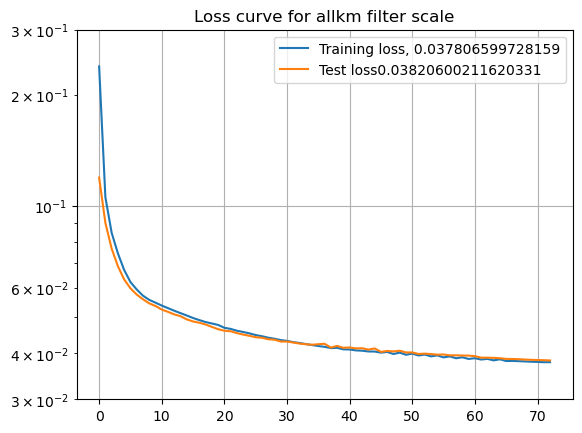

In [17]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.title('Loss curve for '+ L+ 'km filter scale')
plt.grid()
plt.yscale('log')
plt.legend()
plt.ylim([0.03, .3])

#plt.savefig('figures/MOM6_'+L+'km_loss_curve_36_36.png')

In [20]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MOM6_DG_window_3_local_norm_true_out_para_perp'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MOM6_DG_all_window_3_local_norm_true_out_para_perp'+'.nc'
regress_sys.save_weights_nc(model_nc)

In [14]:
ANN_model_large = ML_classes.ANN(shape=[36,36,2], num_in = len(ML_data.input_channels))

In [18]:
regress_sys_large = ML_classes.RegressionSystem(ANN_model_large, local_norm=True)

In [18]:
%%time
regress_sys_large.train_system(ML_data, 31, 1)

NameError: name 'regress_sys_large' is not defined

In [20]:
# Save the checkpoint
CKPT_DIR = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/ckpts_all_MOM6_P2L_window_1_local_norm_true_out_para_perp_size_36_36'
regress_sys.save_checkpoint(CKPT_DIR)

# Save model nc file
model_nc = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/' +'MOM6_P2L_all_window_1_local_norm_true_out_para_perp_size_36_36'+'.nc'
regress_sys.save_weights_nc(model_nc)